In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\ASUS-R-
[nltk_data]     STRIX\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#Importacion de datos de etrenamiento
df = pd.read_excel('data_entrenada_propia_GP.ods', engine='odf')
df

,Unnamed: 0,feedback,codigo,polaridad,Unnamed: 4
0,624927,"muy bien elaborada, se podría incluir ciertos ...",624927,P,NaN
1,543337,La información es ordenada y precisa pero reco...,543337,P,NaN
2,614284,Excelente aporte,614284,P,NaN
3,296130,"En la respuesta que le he puesto 3, ha sido po...",296130,N,NaN
4,555037,"Conciso, excelente",555037,P,NaN
...,...,...,...,...,...
2995,684953,excelente,684953,P,NaN
2996,444203,"Felicidades estimado/a estudiante, excelente t...",444203,P,NaN
2997,666824,Me gusto su presentación,666824,P,NaN
2998,167032,Se entiende en la formulacion de la encuesta q...,167032,P,NaN


In [4]:
df2 = pd.read_csv('Dataset_de_Pruebas_Extendido.csv')
df2

,feedback,polaridad
0,"La experiencia fue excelente, muy recomendada",P
1,"Nunca recibí lo que pedí, pésimo servicio",N
2,No tengo nada relevante que mencionar,NEU
3,Definitivamente lo volvería a comprar,P
4,El paquete estaba incompleto y defectuoso,N
...,...,...
2996,"La experiencia fue regular, ni buena ni mala",NEU
2997,El equipo funciona perfectamente,P
2998,La atención fue deficiente y no cumplieron lo ...,N
2999,"Podría ser mejor, pero no es terrible",NEU


# Limpieza de Datos

In [5]:
# Revisión de datos nulos
print(df.isnull().sum())

Unnamed: 0       0
feedback         5
codigo           0
polaridad        7
Unnamed: 4    2792
dtype: int64


In [6]:
# Eliminar filas con valores nulos en 'feedback' o 'polaridad'
df = df.dropna(subset=['feedback', 'polaridad'])

In [7]:
# Verificar que los valores nulos se eliminaron
print(df.isnull().sum())

Unnamed: 0       0
feedback         0
codigo           0
polaridad        0
Unnamed: 4    2780
dtype: int64


In [8]:
# DataFrame solo con las columnas necesarias
df = df[['polaridad', 'feedback']]

In [9]:
# Revision de la columna 'polaridad'
print(df['polaridad'].value_counts())

polaridad
P         1780
N          552
NEU        330
NONE       322
NUE          2
NEUTRO       1
NOE          1
Name: count, dtype: int64


In [10]:
# Normalizar los nombres de la polaridad
df.loc[(df['polaridad'] == 'NEUTRO') | (df['polaridad'] == 'NUE') | (df['polaridad'] == 'NOE')]

,polaridad,feedback
68,NEUTRO,Muy Bien
253,NUE,Hay variedad de plantas que son medicinales de...
1331,NOE,10 puntos.
1446,NUE,Muy narrativa


In [11]:
# Cambiar valores incorrectos
df.loc[:, 'polaridad'] = df['polaridad'].replace({
    'NEUTRO': 'P',
    'NOE': 'NONE',
    'NUE': 'NEU'
})

In [12]:
# Revision de los cambios en la columna 'polaridad'
print(df['polaridad'].value_counts())

polaridad
P       1781
N        552
NEU      332
NONE     323
Name: count, dtype: int64


In [13]:
df['feedback'] = df['feedback'].astype(str)

In [14]:
df.head()

,polaridad,feedback
0,P,"muy bien elaborada, se podría incluir ciertos ..."
1,P,La información es ordenada y precisa pero reco...
2,P,Excelente aporte
3,N,"En la respuesta que le he puesto 3, ha sido po..."
4,P,"Conciso, excelente"


In [15]:
# Eliminar los datos NONE que no tienen ningun valor
df = df[df['polaridad'] != 'NONE']

In [75]:
# Concatenar los datasets por filas
df = pd.concat([df, df2], ignore_index=True)

# Mostrar el resultado
df

,polaridad,feedback
0,P,"muy bien elaborada, se podría incluir ciertos ..."
1,P,La información es ordenada y precisa pero reco...
2,P,Excelente aporte
3,N,"En la respuesta que le he puesto 3, ha sido po..."
4,P,"Conciso, excelente"
...,...,...
5661,NEU,"La experiencia fue regular, ni buena ni mala"
5662,P,El equipo funciona perfectamente
5663,N,La atención fue deficiente y no cumplieron lo ...
5664,NEU,"Podría ser mejor, pero no es terrible"


<Axes: >

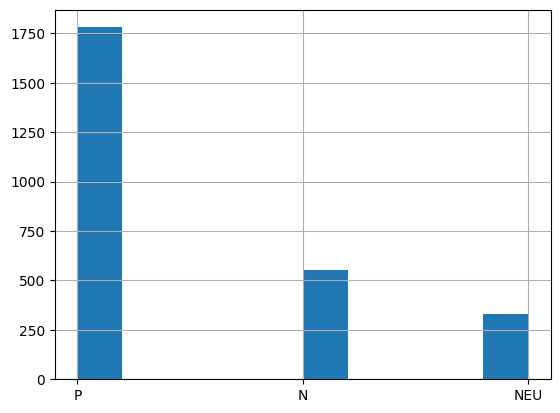

In [16]:
df['polaridad'].hist()

In [17]:
# Filtrar las frases positivas
positivas = df[df['polaridad'] == 'P']

# Seleccionar un subconjunto de frases positivas para eliminar (30%)
fraccion_eliminar = 0.35
positivas_eliminar = positivas.sample(frac=fraccion_eliminar, random_state=42)

# Eliminar las frases seleccionadas del dataset original
df = df.drop(positivas_eliminar.index)
df

,polaridad,feedback
0,P,"muy bien elaborada, se podría incluir ciertos ..."
1,P,La información es ordenada y precisa pero reco...
2,P,Excelente aporte
3,N,"En la respuesta que le he puesto 3, ha sido po..."
4,P,"Conciso, excelente"
...,...,...
2994,N,debería de ver utilizado fotografías tomadas a...
2995,P,excelente
2996,P,"Felicidades estimado/a estudiante, excelente t..."
2998,P,Se entiende en la formulacion de la encuesta q...


<Axes: >

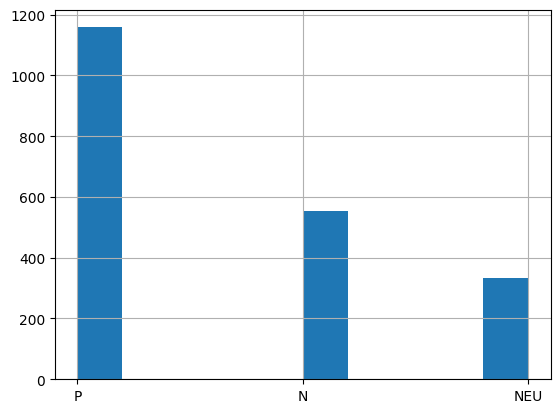

In [18]:
df['polaridad'].hist()

In [19]:
# Crear codigos para cada polaridad
target_map = {'P': 1, 'N': 0, 'NEU': 2}
df['target'] = df['polaridad'].map(target_map)

In [20]:
df

,polaridad,feedback,target
0,P,"muy bien elaborada, se podría incluir ciertos ...",1
1,P,La información es ordenada y precisa pero reco...,1
2,P,Excelente aporte,1
3,N,"En la respuesta que le he puesto 3, ha sido po...",0
4,P,"Conciso, excelente",1
...,...,...,...
2994,N,debería de ver utilizado fotografías tomadas a...,0
2995,P,excelente,1
2996,P,"Felicidades estimado/a estudiante, excelente t...",1
2998,P,Se entiende en la formulacion de la encuesta q...,1


# Preprocesamiento de texto

In [21]:
def limpiar_texto(df):
    # Convertir todas las palabras a minúsculas
    df['feedback'] = df['feedback'].str.lower()

    # Quitar palabras sin valor sintáctico (stop words)
    conservar = {'muy','no','si', 'lo'} #Palabras que se desea conservar
    stop_words = set(stopwords.words('spanish')) - conservar  # Cambia 'spanish' si necesitas otro idioma
    df['feedback'] = df['feedback'].apply(lambda x: ' '.join(
        word for word in x.split() if word not in stop_words
    ))
    return df

In [22]:
df3 = limpiar_texto(df)
df3

,polaridad,feedback,target
0,P,"muy bien elaborada, podría incluir ciertos det...",1
1,P,información ordenada precisa recomendaría resu...,1
2,P,excelente aporte,1
3,N,"respuesta puesto 3, sido significado oración n...",0
4,P,"conciso, excelente",1
...,...,...,...
2994,N,debería ver utilizado fotografías tomadas usua...,0
2995,P,excelente,1
2996,P,"felicidades estimado/a estudiante, excelente t...",1
2998,P,entiende formulacion encuesta infiere encuesta...,1


# Entrenamiento del Modelo

In [23]:
# Division de datos para entrenamiento y prueba
X = df['feedback']
y = df['polaridad']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
X

0       muy bien elaborada, podría incluir ciertos det...
1       información ordenada precisa recomendaría resu...
2                                        excelente aporte
3       respuesta puesto 3, sido significado oración n...
4                                      conciso, excelente
                              ...                        
2994    debería ver utilizado fotografías tomadas usua...
2995                                            excelente
2996    felicidades estimado/a estudiante, excelente t...
2998    entiende formulacion encuesta infiere encuesta...
2999    infografía cumple lo requerido éste caso parti...
Name: feedback, Length: 2042, dtype: object

In [25]:
print(y_train.value_counts())

polaridad
P      927
N      444
NEU    262
Name: count, dtype: int64


In [26]:
# Crear un pipeline para la vecorización y clasificación de los datos de entrenamiento
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=1400, ngram_range=(1, 2))),  # Vectorización
    ('classifier', LogisticRegression())  # Clasificación
])

In [27]:
# Entrenar el modelo
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=1400, ngram_range=(1, 2))),
                ('classifier', LogisticRegression())])

In [28]:
# save
with open('model2.pkl','wb') as f:
    pickle.dump(pipeline,f)

In [29]:
# load
with open('model2.pkl', 'rb') as f:
    clf2 = pickle.load(f)

In [30]:
# Evaluar el modelo
y_pred = clf2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           N       0.73      0.79      0.76       108
         NEU       0.46      0.17      0.25        70
           P       0.82      0.95      0.88       231

    accuracy                           0.77       409
   macro avg       0.67      0.64      0.63       409
weighted avg       0.74      0.77      0.74       409



# Resultados

In [31]:
print ('Entrenamiento:', clf2.score(X_train, y_train))
print ('Prueba:', clf2.score(X_test, y_test))

Entrenamiento: 0.9173300673606859
Prueba: 0.7726161369193154


In [32]:
# Extraer predicciones para entrenamiento y prueba
P_train = clf2.predict(X_train)
P_test = clf2.predict(X_test)

In [33]:
# Obtener el clasificador y vectorizador del pipeline
model = clf2.named_steps['classifier']
vectorizer = clf2.named_steps['vectorizer']

In [34]:
# Calcular matriz de confusión normalizada
cm_train = confusion_matrix(y_train, P_train, normalize='true')
cm_test = confusion_matrix(y_test, P_test, normalize='true')

In [35]:
# Función para graficar matriz de confusión
def plot_cm(cm, title="Matriz de Confusión"):
    classes = ['negativo', 'positivo', 'neutral']  # Ajustar según tus etiquetas
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Objetivo")
    plt.show()

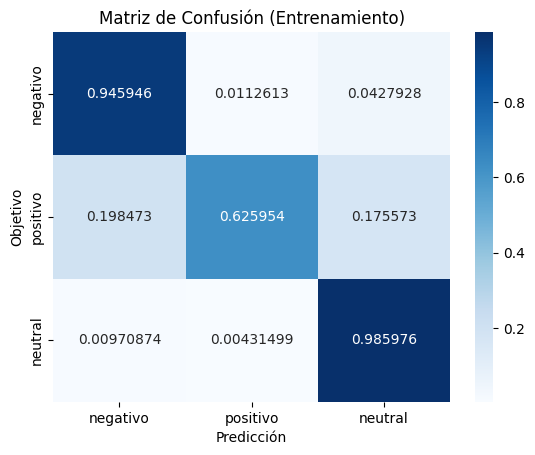

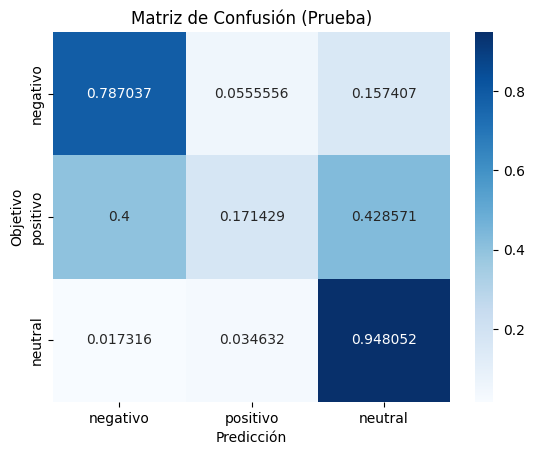

In [36]:
# Graficar matrices de confusión
plot_cm(cm_train, title="Matriz de Confusión (Entrenamiento)")
plot_cm(cm_test, title="Matriz de Confusión (Prueba)")

In [37]:
# Extraer vocabulario y coeficientes
model = clf2.named_steps['classifier']
vectorizer = clf2.named_steps['vectorizer']

word_index_map = vectorizer.vocabulary_
coef = model.coef_[0]

In [38]:
# Diagnóstico de coeficientes
print("Distribución de coeficientes:")
print(f"Mínimo: {np.min(coef)}, Máximo: {np.max(coef)}")

Distribución de coeficientes:
Mínimo: -1.7597041918959162, Máximo: 4.744808369243812


In [39]:
# Ajustar umbrales basados en la distribución
corte_positivo = np.percentile(coef, 90)  # Top 10% más altos
corte_negativo = np.percentile(coef, 10)  # Bottom 10% más bajos

In [40]:
# Mostrar palabras con coeficientes altos (positivas)
print("Palabras más positivas:")
for word, index in word_index_map.items():
    weight = coef[index]
    if weight > corte_positivo:
        print(f"{word}: {weight}")

Palabras más positivas:
mejorar: 0.9221996009897092
no: 4.744808369243812
creo: 0.5157285190002594
presentadas: 0.3857425870021713
aparece: 0.3691766039148103
ningún: 0.3548806518064489
final: 0.3694684554590587
mas: 0.6455965595720162
mejorando: 0.4256106031194681
revisar: 0.4911711267665215
nuevamente: 0.5715934179298444
tarea: 0.6475490043558533
utilizar: 0.4436459963190716
link: 0.6055727813459152
poner: 0.4004173732337996
no puede: 0.43160876597269643
orden: 0.445427096738327
infografía: 0.8115641982556059
palabras: 0.4382187424353536
explicación: 0.8235220697196008
imágenes: 0.8357575899831201
máximo: 0.38398895339694
cada: 0.39977100952180245
falta: 1.7870499471947265
imagen: 0.7879446173283083
realizar: 0.5002732085171671
información: 0.6697350389795813
escueta: 0.4973390538070887
analizar: 0.3781899705807489
organelas: 0.39901316967813616
elaboración: 0.4172138207895403
bibliografia: 0.38259688139246206
respuesta: 0.3662780356877823
mejor: 0.5725357903788637
planteado: 0.46348

In [41]:
# Mostrar palabras con coeficientes bajos (negativas)
print("\nPalabras más negativas:")
for word, index in word_index_map.items():
    weight = coef[index]
    if weight < corte_negativo:
        print(f"{word}: {weight}")


Palabras más negativas:
ortografía: -0.33086278815288156
adecuadas: -0.30951309697145163
parte: -0.33920091718671724
excelente: -1.7597041918959162
éxitos: -0.5590912547220293
excelente trabajo: -0.6062261288583748
éxitos curso: -0.2807330115213042
muy: -1.1840997003320557
bien: -1.3109621095125217
muy bien: -0.7835734735726119
realizado: -0.28743080738086724
buen: -1.4101571251927278
sugerencia: -0.33378314286538463
opinión: -0.6344584676139507
buen trabajo: -1.1422079811333168
aporte: -0.5415702383721932
claras: -0.392816710559965
concepto: -0.4804724594440871
felicidades: -0.841832257429567
felicitaciones: -1.0090971072077966
buena: -1.3106503264821485
entendible: -0.3484046614497312
completamente: -0.2862889389670452
nota: -0.5205020378819654
interés: -0.33474073410677774
compañero: -0.31845270793127844
agua: -0.3363513129383826
muy buen: -0.32070561735720854
correcto: -0.5164413527734101
clara: -0.40584894759219464
desarrollo: -0.6350995302750843
bueno: -0.6506301390417922
sencil

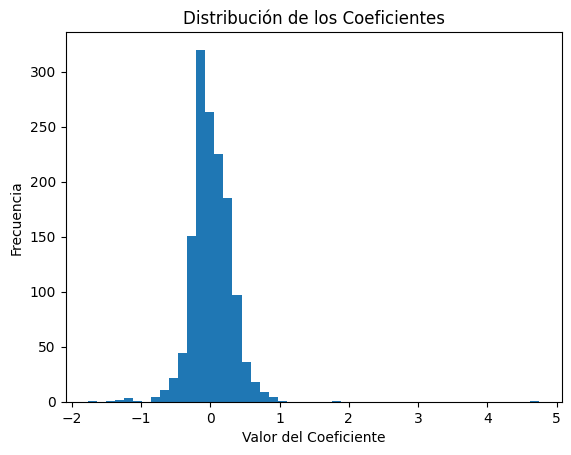

In [42]:
plt.hist(coef, bins=50)
plt.title("Distribución de los Coeficientes")
plt.xlabel("Valor del Coeficiente")
plt.ylabel("Frecuencia")
plt.show()

# Prueba de Modelo

In [50]:
# Frases de prueba
prueba = [
    "El servicio fue excelente, muy recomendado",  # Positiva 
    "No la recomendaria", # Negativa
    "Es un producto aceptable, pero podría mejorar",  # Neutra
    "La película fue increíble", # Positivo
    "El juego fue muy malo", # Negativo
    "Vamos a comer", # Neutras
    "No te diría que la veas", # Neutral
    "Muy malo",
    "malo",
    "Bad"# Negativo
]

In [51]:
# Preprocesar las frases como se hizo en el conjunto de entrenamiento
# Convertir a minúsculas y quitar stop words
prueba_preprocesada = [
    ' '.join(word for word in frase.lower().split() if word not in set(stopwords.words('spanish')))
    for frase in prueba
]

In [52]:
# Vectorizar las frases de prueba
X_prueba = clf2.named_steps['vectorizer'].transform(prueba_preprocesada)

In [53]:
# Predecir con el modelo
predicciones = clf2.named_steps['classifier'].predict(X_prueba)

In [54]:
# Mostrar resultados
for i, frase in enumerate(prueba):
    print(f"Frase: {frase}")
    if predicciones[i] == 'P':
        print(f"Predicción: Positiva")
    elif predicciones[i] == 'N':
        print(f"Predicción: Negativa")
    else:
        print(f"Predicción: Neutra")

Frase: El servicio fue excelente, muy recomendado
Predicción: Positiva
Frase: No la recomendaria
Predicción: Positiva
Frase: Es un producto aceptable, pero podría mejorar
Predicción: Negativa
Frase: La película fue increíble
Predicción: Positiva
Frase: El juego fue muy malo
Predicción: Positiva
Frase: Vamos a comer
Predicción: Positiva
Frase: No te diría que la veas
Predicción: Positiva
Frase: Muy malo
Predicción: Positiva
Frase: malo
Predicción: Positiva
Frase: Bad
Predicción: Positiva
